In [184]:
import os
import torch
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS
import numpy as np
import librosa
from IPython import display

import matplotlib.pyplot as plt
from tqdm import tqdm

In [180]:
# https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html
# Dataset:
#   https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html
#   https://pytorch.org/audio/stable/generated/torchaudio.datasets.SPEECHCOMMANDS.html#torchaudio.datasets.SPEECHCOMMANDS


# tutorial https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html

In [185]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("../data/", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]
    
        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


In [186]:
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

In [187]:
# all waveforms come in 1 second arrays
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

In [188]:
"""
check the max value occuring in the dataset to see if we need to normalize the data.
When we later want to capture audio samples ourselves, we need to check again.
"""
total_max = 0
for i in tqdm(range(len(train_set))):
    waveform = train_set[i][0]
    current_max = waveform.max()
    if current_max > total_max:
        total_max = current_max
if total_max <= 1:
    print(f"The max value is {total_max} and the data obviously comes normalized.")
else:
    print("We should normalize the data.")

100%|██████████| 84843/84843 [00:30<00:00, 2805.06it/s]

The max value is 0.999969482421875 and the data obviously comes normalized.


In [189]:
display.display(display.Audio(waveform, rate=16000))
print(f"Label: {label}")

Label: backward


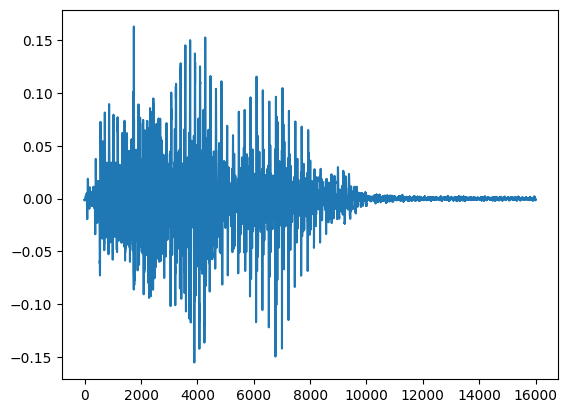

In [190]:
plt.plot(waveform.t().numpy())

In [563]:
# store indices
no_array = []
yes_array = []
for i in range(len(train_set)):
    label = train_set[i][2]
    if label == "no":
        no_array.append(i)
    elif label == "yes":
        yes_array.append(i)

In [564]:
len(yes_array)

3228

3130

In [579]:
def make_spectros(waveform):
    """
    One file holds exactly one second of audio data. This data is cut into pieces of 30ms.
    """
    sample_rate = 16000
    # check if the sample has the correct shape
    if waveform.shape[1] != sample_rate:
        print("sample needs to be one secong long")
        return None

    # Apply a pre-emphasis filter to the audio data
    pre_emphasis = 0.97
    emphasized_audio_data = np.append(waveform[0], waveform[1:] - pre_emphasis * waveform[:-1])

    # corresponds to a window size of 30ms
    window_length_samples = 480
    # corresponds to a stride of 20ms 
    window_stride_samples = 320
    # compute a Hann window
    hann_window = np.hanning(window_length_samples)
    # number of iterations needed to loop through one example
    n_iterations = int(sample_rate / window_stride_samples - 1)
    n_frequency_buckets = 40
    hop_length = 160
    # values for the frequency limits
    lower_freq = 10
    upper_freq = 8000
    # shape of the mfcc coefficients array
    mfcc_depth = 4
    # empty array in shape of final array
    mfcc_array = np.zeros((n_iterations, n_frequency_buckets, mfcc_depth))
    r_avg = np.zeros((n_frequency_buckets,1))

    # set start point of our window
    start_ind = 0
    # set end point of our window
    end_ind = window_length_samples

    for slice in range(n_iterations):
        # apply hanning window
        window = emphasized_audio_data[start_ind:end_ind] * hann_window
        # create the spectrogram
        spectrogram = np.abs(librosa.stft(window, n_fft=window_length_samples, hop_length=hop_length))
        # scale down by non linear Mel function
        mfcc_window = np.abs(librosa.feature.mfcc(S=spectrogram, sr=sample_rate, n_mfcc=n_frequency_buckets, 
                                        n_fft=window_length_samples, hop_length=hop_length, 
                                        fmin=lower_freq, fmax=upper_freq))
        # append the array to mfcc coefficients to the array    
        mfcc_array[slice, :] = mfcc_window

        # keep an average of the frequency buckets
        # TODO: to make it more accurate, we could cache it and build an average over all audio files
        r_avg = np.mean((mfcc_array[:slice]), axis=2)
        if slice > 0:
            # subtract running average from current value in each bucket -> the problem arises that we get negative values this way.
            # TODO: do this matrix wise
            # loop over the bins
            for i in range(mfcc_array[slice].shape[0]):
                # loop over values of each bin
                for j in range(mfcc_array[slice].shape[1]):
                    # we could either take max(0, value) or take the absolute value, which would make limited sense in my opinion because 
                    # we want to get rid of the noise
                    noise_cancelled = np.max([mfcc_array[slice][i][j] - r_avg[0][i], 1e-10])
                    # apply log scale
                    noise_cancelled = np.abs(np.log10(noise_cancelled))
                    # add to array
                    mfcc_array[slice][i][j] = noise_cancelled
            # break
            

        # increase starting point by window size
        start_ind += window_stride_samples
        end_ind += window_stride_samples

    # take the average over last axis
    mfcc_array = np.mean(mfcc_array, axis=2)

    assert(mfcc_array.shape == (n_iterations, n_frequency_buckets))

    return mfcc_array

In [578]:
train_set[yes_array[1]][0].shape[1]

14861

In [571]:
make_spectros(train_set[yes_array[1]][0])

ValueError: operands could not be broadcast together with shapes (461,) (480,) 

sample needs to be one secong long


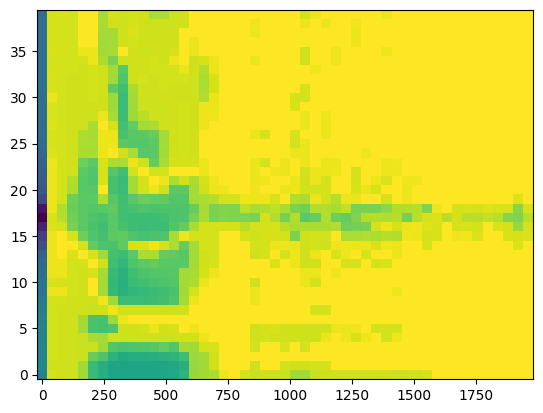

In [582]:
for i in range(4):
    wf = train_set[yes_array[i]][0]
    spec = make_spectros(wf)
    if spec is not None:
        plot_spectrogram(spec)

In [570]:
fig, axes = plt.subplots(2, figsize=(12, 8))

1

In [568]:
def plot_spectrogram(spectrogram):
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    plt.pcolormesh(X, Y, log_spec)

In [557]:
avg_mfcc = np.mean(mfcc_array, axis=2)
print(avg_mfcc.shape)

(49, 40)


In [560]:
tcnt = 0
for i in range(1, mfcc_array.shape[0]):
    truth = mfcc_array[i-1] == mfcc_array[i]
    if truth.all():
        print(f"{i} and {i-1} are the same")
        tcnt += 1
print(tcnt)


0


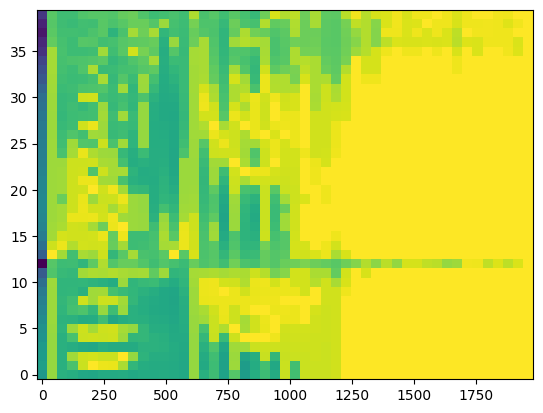

In [561]:
plot_spectrogram(avg_mfcc)

In [ ]:




# Apply the microfrontend preprocessing method
window_size_ms = 30.0
window_stride_ms = 20.0
# feature_bin_count = 40
dct_coefficient_count = 10
lower_frequency_limit = 10
upper_frequency_limit = 8000
sample_rate = 16000

# Apply the window function to the spectrogram
window_length_samples = int(round(window_size_ms * sample_rate / 1000))
window_stride_samples = int(round(window_stride_ms * sample_rate / 1000))
window = np.hanning(window_length_samples)
num_frames = 40
# set up the array
mfccs = np.zeros((num_frames, dct_coefficient_count))

# populate the array
for frame in range(num_frames):
    start = frame * window_stride_samples
    end = start + window_length_samples
    windowed_spec = spectrogram[:, start:end] * window
    # Mel-Frequency Cepstral Coefficients
    mfcc = librosa.feature.mfcc(
        S=windowed_spec,
        sr=sample_rate,
        n_mfcc=dct_coefficient_count,
        n_fft=480,
        hop_length=180,
        fmin=lower_frequency_limit,
        fmax=upper_frequency_limit
    )
    mfccs[frame, :] = mfcc

# Quantize the MFCC data
quantized_mfccs = (np.clip(mfccs, -80.0, 16.0) + 80.0) * (255.0 / 96.0)
quantized_mfccs = np.round(quantized_mfccs).astype(np.uint8)

# Reshape the MFCC data to the required shape (num_frames, num_dct_coeffs)
num_dct_coeffs = quantized_mfccs.shape[1]
reshaped_mfccs = quantized_mfccs.reshape((1, num_frames, num_dct_coeffs))

# Apply the window stride
window_stride = 20
start = 0
end = window_stride * reshaped_mfccs.shape[1]
stride_mfccs = reshaped_mfccs[:, start:end:window_stride, :]

# Convert the MFCC data to a tensor
mfcc_tensor = np.array(stride_mfccs, dtype=np.float32)

# Normalize the data to have zero mean and unit variance
mean = np.mean(mfcc_tensor)
std = np.std(mfcc_tensor)
normalized_mfcc_tensor = (mfcc_tensor - mean) / std